## Import libraries

In [1]:
import requests
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
pd.set_option('display.max_columns', 0)
import random

In [2]:
secrets_file = open("secrets.txt","r")
string = secrets_file.read()
string.split('\n')
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

## Scrape top100 hits from Popvortex

In [80]:
url = "https://www.popvortex.com/music/charts/top-100-songs.php"

#download html with a get request
response = requests.get(url)
response.status_code

#parse html (create the 'soup')
soup = BeautifulSoup(response.content, "html.parser")

In [81]:
soup.select("#chart-position-1 > div.chart-content.col-xs-12.col-sm-8 > p")

[<p class="title-artist"><cite class="title">FLOWER</cite><em class="artist">JISOO</em></p>]

In [82]:
soup.select("div.chart-content.col-xs-12.col-sm-8 > p > cite")[0].get_text()

'FLOWER'

In [83]:
soup.select("div.chart-content.col-xs-12.col-sm-8 > p > em")[0].get_text()

'JISOO'

In [84]:
title = []
artist = []

num_iter = len(soup.select("div.chart-content.col-xs-12.col-sm-8 > p > cite"))
tlist = soup.select("div.chart-content.col-xs-12.col-sm-8 > p > cite")
alist = soup.select("div.chart-content.col-xs-12.col-sm-8 > p > em")

# iterate through the result set and retrive all the data
for i in range(num_iter):
    title.append(tlist[i].get_text())
    artist.append(alist[i].get_text())

In [85]:
top100 = pd.DataFrame({"title":title, "artist":artist})

In [86]:
top100.head()

,title,artist
0,FLOWER,JISOO
1,Last Night,Morgan Wallen
2,Flowers,Miley Cyrus
3,Fast Car,Luke Combs
4,Thank God I Do,Lauren Daigle


##  PopVortex Song Recommender

In [87]:
def popsongrecommender():
    song = input("Enter song name: ")
    artist = input("Enter artist name: ")
    
    for i in range(len(top100.values)):
        if (song in top100.values[i][0]) & (artist in top100.values[i][1]):
            recommendation = top100[(top100['title'] != song) & (top100['artist'] != artist)].iloc[random.randint(0,99)]
            return "We recommend: " + recommendation.title + " by " + recommendation.artist 
        
    for i in range(len(top100.values)): 
        if (song not in top100.values[i][0]) & (artist not in top100.values[i][1]):
            return "Sorry, no recommendations available"

In [89]:
popsongrecommender()

Enter song name: Flowers
Enter artist name: Miley Cyrus


"We recommend: I Ain't Worried by OneRepublic"

## Add spotify songs

In [16]:
spot_df = pd.read_csv("spotifytracks.csv")

In [17]:
#drop duplicate column
spot_df = spot_df.drop(['features_uri', 'uri', 'features_type', 'features_track_href', 'features_analysis_url'], axis=1)  

In [18]:
#rename columns
spot_df.columns = spot_df.columns.str.replace(r"features_", "")

In [19]:
spot_df['valence'] = spot_df['valence'].round(decimals=3)

In [20]:
spot_df.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Run Away,dvsn,0.764,0.330,2,-12.801,0,0.0427,0.1000,0.506000,0.1390,0.069,119.978,0xD824qQkuonQNHe2dSeI4,140293,4
1,L$D,A$AP Rocky,0.598,0.252,2,-15.086,1,0.0644,0.1940,0.133000,0.0992,0.035,120.064,4S7YHmlWwfwArgd8LfSPud,238307,4
2,Studio,ScHoolboy Q,0.709,0.589,8,-7.776,0,0.0433,0.0507,0.000000,0.0585,0.580,133.922,29gsi1zZrZxdStACmTQB0Z,278067,3
3,OTW,Khalid,0.652,0.678,2,-6.183,1,0.0541,0.1830,0.000033,0.1060,0.280,72.989,6Hgh47WXVKtXN5zGOu0hjI,263014,4
4,Silence,Marshmello,0.520,0.761,4,-3.093,1,0.0853,0.2560,0.000005,0.1700,0.286,141.971,7vGuf3Y35N4wmASOKLUVVU,180823,4


## Add more songs from kaggle

In [21]:
newdata = pd.read_csv("dataset.csv")

In [22]:
newdata = newdata.drop(['Unnamed: 0', 'album_name', 'track_genre', 'explicit', 'popularity'], axis=1)  

In [23]:
newdata.rename(columns = {'track_id':'id', 'artists':'artist', 'track_name':'song'}, inplace = True)

In [24]:
newdata = newdata[['song','artist','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','id','duration_ms','time_signature']]

In [25]:
newdata['energy'] = newdata['energy'].round(decimals=3)

In [26]:
newdata.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Comedy,Gen Hoshino,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,5SuOikwiRyPMVoIQDJUgSV,230666,4
1,Ghost - Acoustic,Ben Woodward,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4qPNDBW1i3p13qLCt0Ki3A,149610,4
2,To Begin Again,Ingrid Michaelson;ZAYN,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,1iJBSr7s7jYXzM8EGcbK5b,210826,4
3,Can't Help Falling In Love,Kina Grannis,0.266,0.060,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,6lfxq3CG4xtTiEg7opyCyx,201933,3
4,Hold On,Chord Overstreet,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,5vjLSffimiIP26QG5WcN2K,198853,4


## Concat Dataframes

In [27]:
alltracks = pd.concat([spot_df, newdata], axis=0)
alltracks.shape

(119186, 16)

In [28]:
alltracks.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Run Away,dvsn,0.764,0.330,2,-12.801,0,0.0427,0.1000,0.506000,0.1390,0.069,119.978,0xD824qQkuonQNHe2dSeI4,140293,4
1,L$D,A$AP Rocky,0.598,0.252,2,-15.086,1,0.0644,0.1940,0.133000,0.0992,0.035,120.064,4S7YHmlWwfwArgd8LfSPud,238307,4
2,Studio,ScHoolboy Q,0.709,0.589,8,-7.776,0,0.0433,0.0507,0.000000,0.0585,0.580,133.922,29gsi1zZrZxdStACmTQB0Z,278067,3
3,OTW,Khalid,0.652,0.678,2,-6.183,1,0.0541,0.1830,0.000033,0.1060,0.280,72.989,6Hgh47WXVKtXN5zGOu0hjI,263014,4
4,Silence,Marshmello,0.520,0.761,4,-3.093,1,0.0853,0.2560,0.000005,0.1700,0.286,141.971,7vGuf3Y35N4wmASOKLUVVU,180823,4


## Scaling and Clustering

#### Drop categoricals before scaling

In [29]:
justfeat = alltracks.drop(['song','artist','id'], axis=1)

In [30]:
justfeat.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.764,0.330,2,-12.801,0,0.0427,0.1000,0.506000,0.1390,0.069,119.978,140293,4
1,0.598,0.252,2,-15.086,1,0.0644,0.1940,0.133000,0.0992,0.035,120.064,238307,4
2,0.709,0.589,8,-7.776,0,0.0433,0.0507,0.000000,0.0585,0.580,133.922,278067,3
3,0.652,0.678,2,-6.183,1,0.0541,0.1830,0.000033,0.1060,0.280,72.989,263014,4
4,0.520,0.761,4,-3.093,1,0.0853,0.2560,0.000005,0.1700,0.286,141.971,180823,4


#### Scale features

In [31]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(justfeat)
featscale = transformer.transform(justfeat)
audfeat = pd.DataFrame(featscale,columns=justfeat.columns)

In [32]:
audfeat.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.104103,-1.249610,-0.929071,-0.926769,-1.307412,-0.422267,-0.644035,1.169213,-0.386636,-1.573036,-0.067468,-0.824314,0.215403
1,0.148839,-1.564078,-0.929071,-1.388305,0.764870,-0.222519,-0.358311,-0.055184,-0.597927,-1.705151,-0.064599,0.103814,0.215403
2,0.787600,-0.205417,0.756082,0.088205,-1.307412,-0.416744,-0.793888,-0.491766,-0.813996,0.412570,0.397716,0.480315,-2.111945
3,0.459587,0.153399,-0.929071,0.409967,0.764870,-0.317330,-0.391747,-0.491659,-0.561827,-0.753148,-1.635063,0.337773,0.215403
4,-0.300020,0.488024,-0.367353,1.034101,0.764870,-0.030136,-0.169855,-0.491749,-0.222062,-0.729834,0.666237,-0.440521,0.215403


#### Get optimal K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

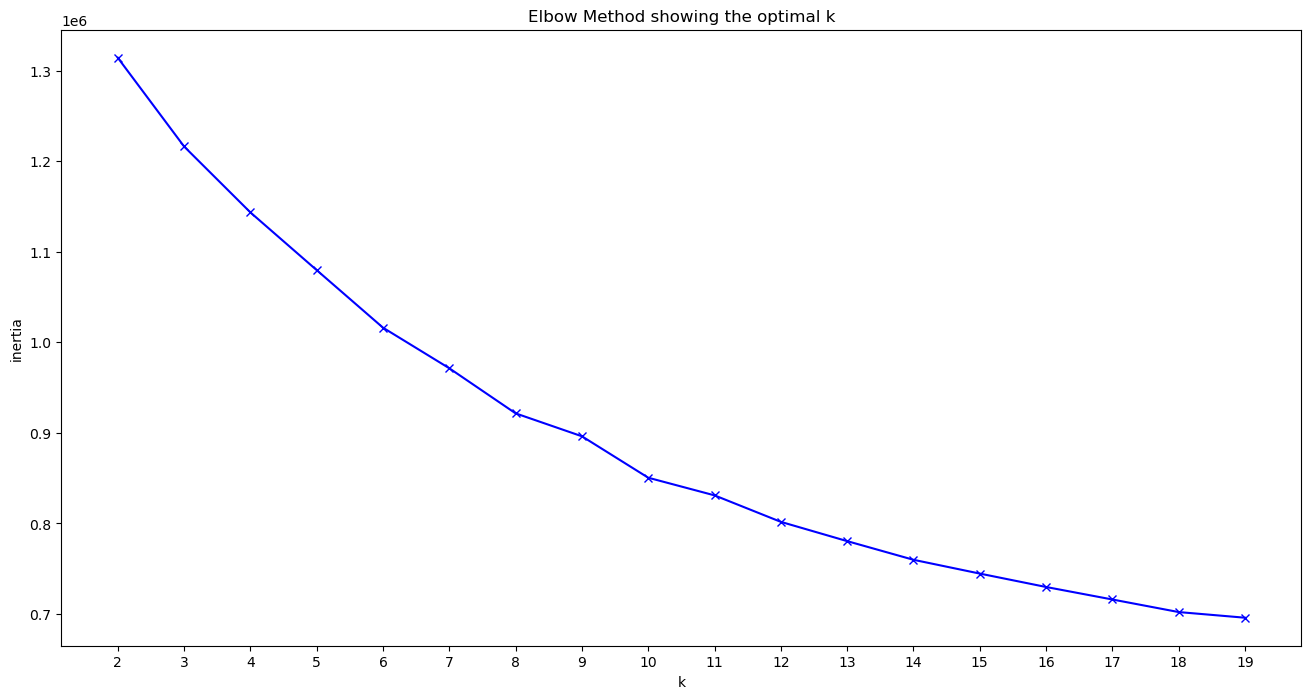

In [120]:
import numpy as np
from sklearn.cluster import KMeans
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=540)
    kmeans.fit(audfeat)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

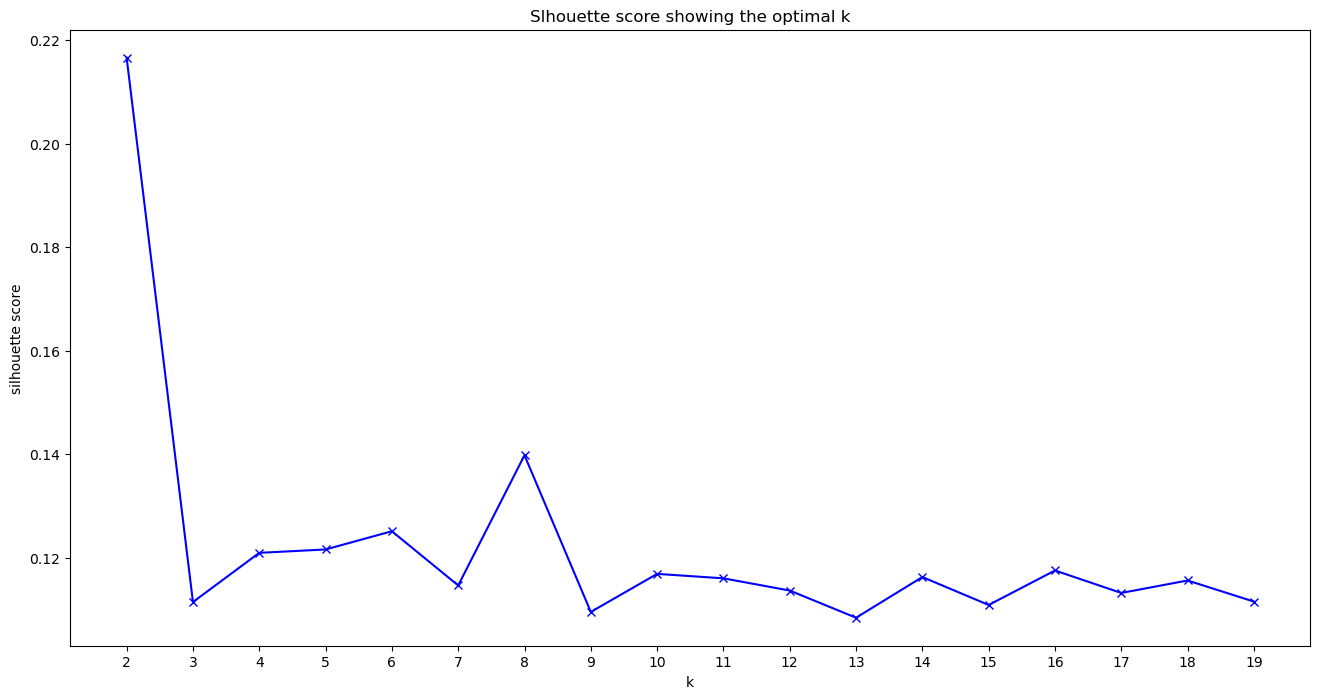

In [121]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=540)
    kmeans.fit(audfeat)
    silhouette.append(silhouette_score(audfeat, kmeans.predict(audfeat)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

#### Use optimal K to make clusters

In [51]:
#Chose 25 after doing some tests with K's
kmeans = cluster.KMeans(n_clusters=25)
kmeans.fit(audfeat)
pred = kmeans.predict(audfeat)
pred

array([24,  1, 21, ...,  6, 22,  6], dtype=int32)

In [2]:
#pd.Series(pred).value_counts().sort_index()

#### Add cluster numbers to dataframe

In [53]:
alltracks['clusters'] = pred

In [54]:
alltracks.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,clusters
0,Run Away,dvsn,0.764,0.330,2,-12.801,0,0.0427,0.1000,0.506000,0.1390,0.069,119.978,0xD824qQkuonQNHe2dSeI4,140293,4,24
1,L$D,A$AP Rocky,0.598,0.252,2,-15.086,1,0.0644,0.1940,0.133000,0.0992,0.035,120.064,4S7YHmlWwfwArgd8LfSPud,238307,4,1
2,Studio,ScHoolboy Q,0.709,0.589,8,-7.776,0,0.0433,0.0507,0.000000,0.0585,0.580,133.922,29gsi1zZrZxdStACmTQB0Z,278067,3,21
3,OTW,Khalid,0.652,0.678,2,-6.183,1,0.0541,0.1830,0.000033,0.1060,0.280,72.989,6Hgh47WXVKtXN5zGOu0hjI,263014,4,4
4,Silence,Marshmello,0.520,0.761,4,-3.093,1,0.0853,0.2560,0.000005,0.1700,0.286,141.971,7vGuf3Y35N4wmASOKLUVVU,180823,4,19


## Song Recommeder for GNOD

In [95]:
def songrecommender():
    song = input("Enter song name: ")
    artist = input("Enter artist name: ")
    
    #songs in top100 playlist
    for i in range(len(top100.values)):
        if (song in top100.values[i][0]) & (artist in top100.values[i][1]):
            recommendation = top100[(top100['title'] != song) & (top100['artist'] != artist)].iloc[random.randint(0,99)]
            return "We recommend: " + recommendation.title + " by " + recommendation.artist 
    
    #songs not in top100 playlist
    for i in range(len(alltracks.values)): 
        if (song not in top100.values[i][0]) & (artist not in top100.values[i][1]):
                #get features from spotify
                track_id = sp.search(q='artist:' + artist + ' track:' + song, type='track') #found on stackov
                songuri = track_id["tracks"]["items"][0]["uri"] 
                get_feat = sp.audio_features(songuri)
                
                #drop categoricals
                featdf = pd.DataFrame(get_feat)
                featdf = featdf.drop(['type','id','uri','track_href','analysis_url'], axis=1)
                
                #scale features
                featnorm = transformer.transform(featdf)
                featnorm = pd.DataFrame(featnorm,columns=featdf.columns)
                
                #get cluster and recommend song in cluster
                clustnum = kmeans.predict(featnorm)[0]
                cluster = alltracks[alltracks['clusters'] == clustnum]
                recommendation = cluster[(cluster['song'] != song) & (cluster['artist'] != artist)].iloc[random.randint(0,len(cluster))]
                return "We recommend: " + recommendation.song + " by " + recommendation.artist + ".  " "Link to song: " + "https://open.spotify.com/track/" + recommendation.id + " "
                        

#### Test with a song from the Hot100 playlist

In [69]:
songrecommender()

Enter song name: Made You Look
Enter artist name: Meghan Trainor


'We recommend: Red Ruby Da Sleeze (Sped Up) [feat. Xxtristanxo & Speed Radio] by Nicki Minaj, Xxtristanxo & Speed Radio'

#### Test with a song not in Hot100 playlist

In [56]:
songrecommender()

Enter song name: Pepas
Enter artist name: Farruko


'We recommend: Fall by Bassjackers;L3N.  Link to song: https://open.spotify.com/track/77gg2iID0drmIb7bvj3pqo '

#### Testing to see if it picks from right cluster

In [1]:
#alltracks[alltracks['clusters'] == 16]

In [58]:
songrecommender()

Enter song name: Electric Fan (Sound Masking Fan)
Enter artist name: Electric Dreams


'We recommend: Internal Flight (Remastered) by Estas Tonne.  Link to song: https://open.spotify.com/track/0PINNy1r5eEILOuHpnjl5d '